In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

LABEL :  5


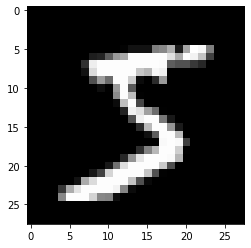

In [ ]:
image, label = next(iter(train))

import matplotlib.pyplot as plt

plt.imshow(image.numpy().reshape(28,28),cmap = 'gray')

print('LABEL : ' , label)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        dropout_rate = 0.01

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = self.gap(x)

        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [ ]:
model = Net()
model = Net().to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1, 16,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 15

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    
    correct_classified = 0
    for batch_number , (x_train,y_train) in enumerate(train_loader):
        
        batch_number+=1
        
        x_train,y_train = x_train.to(device), y_train.to(device)

        # print(x_train.shape)
        pred = model.forward(x_train)

        # print(pred.shape)
        # print(y_train.shape)
        loss = criterion(pred,y_train)
        
        #pred.argmax(dim=1, keepdim=True)
        #PyTorch .eq() function to do this, which compares the values in two tensors and if they match, returns a 1. If they don’t match, it returns a 0:
        #correct += pred.eq(target.view_as(pred)).sum().item()
        predicted = torch.max(pred.data ,1)[1]
        correct_classified += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_number%100 == 0:
            
            acc = round((correct_classified.item())/(batch_number*128),5)
            print(f'(TRAIN) Epoch: {i:4} batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
        
    train_losses.append(loss) 
    train_correct.append(correct_classified)
    
    
    with torch.no_grad():
        
        test_loss = []
        correct_classified = 0
        for batch_number , (x_test,y_test) in enumerate(test_loader):
        
            x_test,y_test = x_test.to(device), y_test.to(device)
            pred = model.forward(x_test)
            loss = criterion(pred,y_test)
            test_losses.append(loss)
            
            correct_classified += (torch.max(pred,1)[1] == y_test).sum()
        
        avg_loss = torch.mean(torch.tensor(test_losses))
        test_losses.append(avg_loss)
        test_correct.append(correct_classified)
        
        acc = round(correct_classified.item()/10000,5)
        print('(TEST) Correct_classified : ' , correct_classified.item() ,' of 10000')
        print(f'(TEST) Epoch: {i:4} Loss : {avg_loss:4.4} Acc : {acc:4.5}')
        print('\n','*'*60 , '\n')

(TRAIN) Epoch:    0 batch_number:  100 Loss : 0.8778 Acc : 0.75617
(TRAIN) Epoch:    0 batch_number:  200 Loss : 0.5949 Acc : 0.84273
(TRAIN) Epoch:    0 batch_number:  300 Loss : 0.4565 Acc : 0.87919
(TRAIN) Epoch:    0 batch_number:  400 Loss : 0.3606 Acc : 0.89922
(TEST) Correct_classified :  9763  of 10000
(TEST) Epoch:    0 Loss : 0.3174 Acc : 0.9763

 ************************************************************ 

(TRAIN) Epoch:    1 batch_number:  100 Loss : 0.3077 Acc : 0.97094
(TRAIN) Epoch:    1 batch_number:  200 Loss : 0.2918 Acc : 0.97383
(TRAIN) Epoch:    1 batch_number:  300 Loss : 0.2732 Acc : 0.97385
(TRAIN) Epoch:    1 batch_number:  400 Loss : 0.2153 Acc : 0.97479
(TEST) Correct_classified :  9839  of 10000
(TEST) Epoch:    1 Loss : 0.2507 Acc : 0.9839

 ************************************************************ 

(TRAIN) Epoch:    2 batch_number:  100 Loss : 0.1439 Acc : 0.97695
(TRAIN) Epoch:    2 batch_number:  200 Loss : 0.1366 Acc : 0.97922
(TRAIN) Epoch:    2 